In [1]:
from diffmain import *
from DataL import *
import glob
import sys
import os
import re
import torch    
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pdb

[[[0.7490196  0.6745098  0.65882355]
  [0.7529412  0.6784314  0.654902  ]
  [0.75686276 0.6627451  0.64705884]
  ...
  [0.6784314  0.5058824  0.32156864]
  [0.65882355 0.49411765 0.30588236]
  [0.6431373  0.47843137 0.28235295]]

 [[0.78039217 0.69803923 0.6784314 ]
  [0.78039217 0.69803923 0.6784314 ]
  [0.7764706  0.6862745  0.6627451 ]
  ...
  [0.65882355 0.49019608 0.3137255 ]
  [0.6431373  0.47843137 0.2901961 ]
  [0.6313726  0.46666667 0.2784314 ]]

 [[0.7921569  0.7019608  0.6784314 ]
  [0.78431374 0.69411767 0.6627451 ]
  [0.77254903 0.6784314  0.6392157 ]
  ...
  [0.6431373  0.48235294 0.30980393]
  [0.63529414 0.4745098  0.3019608 ]
  [0.62352943 0.4627451  0.28235295]]

 ...

 [[0.36078432 0.23921569 0.16078432]
  [0.40392157 0.2901961  0.21960784]
  [0.52156866 0.4117647  0.35686275]
  ...
  [0.30980393 0.25490198 0.21176471]
  [0.33333334 0.27058825 0.21960784]
  [0.3254902  0.2627451  0.21176471]]

 [[0.34117648 0.22745098 0.15686275]
  [0.4627451  0.34901962 0.28627452]


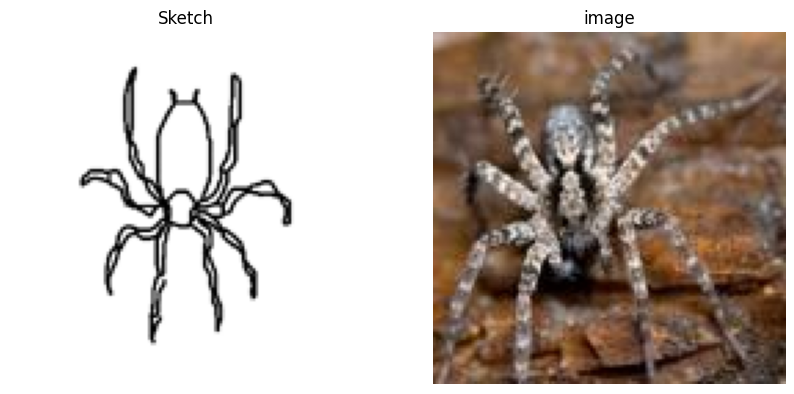

In [22]:

photos_dir = '/Users/deniskaanalpay/Desktop/CMU/Term_2/18786_Intro_to_DL/SketchtoImage/rendered_256x256/256x256/photo/resized'
sketches_dir = '/Users/deniskaanalpay/Desktop/CMU/Term_2/18786_Intro_to_DL/SketchtoImage/rendered_256x256/256x256/sketch/resized'

transform = transforms.Compose([transforms.ToTensor()]) 
SketchySet = SketchyDataset(sketches_dir, photos_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(SketchySet, batch_size=256)


i=random.randint(0,len(SketchySet)-1)
sk,im = SketchySet[i]

# Convert the tensors back to numpy arrays
sk = sk.numpy()
im = im.numpy()

sk=np.array(sk).transpose((1,2,0))
im=np.array(im).transpose((1,2,0))
print(im)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sk)
ax[0].set_title('Sketch')
ax[0].axis('off')

ax[1].imshow(im)
ax[1].set_title('image')
ax[1].axis('off')

plt.show()



In [23]:
diffusion_steps = 1000
architecture = "UNet"
sampling_steps = 250
DDIM = False
local_rank = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [30]:
model = unets.__dict__[architecture](
    image_size=128,
    in_channels=3,
    out_channels=3)


diffusion = GuassianDiffusion(diffusion_steps, device = device)

lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.001)

In [32]:
epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=lr)
model.train()
for epoch in range(epochs):
    for step, (photo, sketch) in enumerate(train_loader):
        assert (photo.max().item() <= 1) and (0 <= photo.min().item())
        photo = photo.to(device)
        sketch = sketch.to(device)
        photo, sketch = (2 * photo - 1, sketch)

        t = torch.randint(diffusion.timesteps, (len(photo),), dtype=torch.int64).to(device)
        
        xt, eps = diffusion.sample_from_forward_process(photo, t)
        pred_eps = model(xt, t, y = sketch)

        loss = ((pred_eps - eps) ** 2).mean()
        loss=loss/4
        loss.backward()
        if step%4 == 0:
            optimizer.step()
            optimizer.zero_grad()  

    print("Epoch: ", epoch)
    print("Loss: ", loss.item())

: 

In [ ]:
torch.save(model.state_dict(), 'model.pth')